# PREpiBind-ESMC-300M

### Install dependencies

In [1]:
# !git clone https://github.com/daylight-00/PREpiBind
# %cd PREpiBind
# !pip install esm

### Dataset Preparation

In [6]:
import pandas as pd
import ipywidgets as widgets
from IPython.display import display, clear_output

# 1. DataFrame 불러오기

mhc_map_l = 'data/mhc_mapping_light.csv'
mhc_map_f = 'data/mhc_mapping.csv'
df_map = pd.read_csv(mhc_map_l)
mhc_map = mhc_map_l

# 2. 체크박스 생성
use_full_hla = widgets.Checkbox(
    value=False,
    description="Use full HLA",
    style={'description_width': 'initial'}
)
output = widgets.Output()

display(use_full_hla, output)

# 3. 체크박스 변경시 동작 함수 (global 명시)
def on_hla_checkbox_change(change):
    global df_map, mhc_map
    with output:
        clear_output()
        if change['new']:
            mhc_map = mhc_map_f
            df_map = pd.read_csv(mhc_map)
            print("Full HLA 매핑 사용 (row 수: {})".format(len(df_map)))
        else:
            mhc_map = mhc_map_l
            df_map = pd.read_csv(mhc_map)
            print("Light HLA 매핑 사용 (row 수: {})".format(len(df_map)))

use_full_hla.observe(on_hla_checkbox_change, names='value')

# 최초 1회 기본값 미리보기
with output:
    print("Light HLA 매핑 사용 (row 수: {})".format(len(df_map)))
    # display(df_map.head(3))


Checkbox(value=False, description='Use full HLA', style=CheckboxStyle(description_width='initial'))

Output()

In [ ]:
import ipywidgets as widgets
from IPython.display import display, clear_output
import pandas as pd
import os

df_map['Chain'] = df_map['HLA_Name'].str.replace('HLA-', '')
df_map_a = df_map[df_map['HLA_Name'].str.contains('A')]
df_map_b = df_map[df_map['HLA_Name'].str.contains('B')]
hla_list_a = df_map_a['HLA_Name'].sort_values().unique().tolist()
hla_list_b = df_map_b['HLA_Name'].sort_values().unique().tolist()

df = pd.DataFrame(columns=['MHC', 'MHC_alpha', 'MHC_beta', 'Epitope'])

file_path_box = widgets.Text(
    value='data/dataset.csv',
    placeholder='CSV 경로 입력 (예: ./dataset.csv)',
    description='파일 경로:',
    style={'description_width': 'initial'}
)
load_button = widgets.Button(description="CSV 불러오기")
add_button = widgets.Button(description="추가")
export_button = widgets.Button(description="CSV 내보내기")
reset_button = widgets.Button(description="초기화", button_style='danger')  # [1] 버튼 생성
mhc_alpha_dropdown = widgets.Dropdown(
    options=hla_list_a, value='HLA-DRA*01:01', description="MHC alpha:", style={'description_width': 'initial'}
)
mhc_beta_dropdown = widgets.Dropdown(
    options=hla_list_b, value='HLA-DRB1*01:01', description="MHC beta:", style={'description_width': 'initial'}
)
epitope_textbox = widgets.Text(
    value='', placeholder='최대 15자, 대문자로 입력', description='Epitope:', style={'description_width': 'initial'}
)
epitope_msg = widgets.HTML("현재 0/15자 입력 중")
output_area = widgets.Output()

def refresh_ui():
    with output_area:
        clear_output()
        if df.empty:
            df_widget = widgets.HTML('<b>입력된 데이터가 없습니다.</b>')
        else:
            df_widget = widgets.HTML(df.tail(5).to_html(index=False))
        ui = widgets.VBox([
            widgets.HBox([mhc_alpha_dropdown, mhc_beta_dropdown, epitope_textbox, add_button]),
            epitope_msg,
            widgets.HBox([file_path_box, load_button, export_button, reset_button]),  # [2] 버튼 추가
            df_widget
        ])
        display(ui)

def add_row(_):
    global df
    alpha, beta, epitope = mhc_alpha_dropdown.value, mhc_beta_dropdown.value, epitope_textbox.value
    if not (alpha and beta and epitope.strip()):
        with output_area:
            clear_output()
            display(widgets.HTML('<b style="color:red;">MHC alpha, MHC beta, Epitope 모두 입력해야 합니다.</b>'))
            refresh_ui()
    else:
        mhc = alpha + '_' + beta
        df.loc[len(df)] = [mhc, alpha, beta, epitope]
        epitope_textbox.value = ""
        refresh_ui()

def export_csv(_):
    path = file_path_box.value
    with output_area:
        clear_output()
        df.to_csv(path, index=False)
        display(widgets.HTML('<b>저장되었습니다: ./tmp/inputs.csv</b>'))
        refresh_ui()

def load_csv(_):
    global df
    path = file_path_box.value
    with output_area:
        clear_output()
        if not os.path.isfile(path):
            display(widgets.HTML(f'<b style="color:red;">파일을 찾을 수 없습니다: {path}</b>'))
        else:
            try:
                df = pd.read_csv(path)
                display(widgets.HTML(f'<b>불러온 파일: {path}<br>상위 3개 행:</b>'))
                display(widgets.HTML(df.head(3).to_html(index=False)))
            except Exception as e:
                display(widgets.HTML(f'<b style="color:red;">파일 읽기 실패: {str(e)}</b>'))
        refresh_ui()

def epitope_textbox_change(change):
    new_val = change['new'].upper()[:15]
    if new_val != epitope_textbox.value:
        epitope_textbox.value = new_val
        return
    epitope_msg.value = f"현재 {len(epitope_textbox.value)}/15자 입력 중"

def reset_df(_):   # [3] 리셋 함수 추가
    global df
    df = pd.DataFrame(columns=['MHC', 'MHC_alpha', 'MHC_beta', 'Epitope'])
    with output_area:
        clear_output()
        display(widgets.HTML('<b style="color:green;">DataFrame이 초기화되었습니다.</b>'))
        refresh_ui()

add_button.on_click(add_row)
export_button.on_click(export_csv)
load_button.on_click(load_csv)
reset_button.on_click(reset_df)    # [4] 버튼 이벤트 연결
epitope_textbox.observe(epitope_textbox_change, names='value')

display(output_area)
refresh_ui()


Output()

### Prediciton Preferences

숫자 직접 입력할 경우 엔터 치기

In [10]:
import ipywidgets as widgets

num_workers = widgets.IntSlider(
    value=8 if os.cpu_count() > 8 else os.cpu_count(),
    description="Num workers:",
    style={'description_width': 
           'initial'},
    min=0,
    max= os.cpu_count()
)
display(num_workers)

batch_size = widgets.IntSlider(
    value=512 if len(df) > 512 else len(df),
    description="Batch size:",
    style={'description_width': 'initial'},
    min=1,
    max=len(df)
)
display(batch_size)

plot_kde = widgets.Checkbox(
    value=True,
    description="Plot KDE",
    style={'description_width': 'initial'}
)
display(plot_kde)

use_compile = widgets.Checkbox(
    value=False,
    description="Use torch compile",
    style={'description_width': 'initial'}
)
display(use_compile)

show_config = widgets.Checkbox(
    value=False,
    description="Show config",
    style={'description_width': 'initial'}
)
display(show_config)

out_path = widgets.Text(
    value='outputs',
    placeholder='출력 폴더 경로 입력 (예: ./outputs)',
    description='출력 폴더:',
    style={'description_width': 'initial'}
)
display(out_path)

IntSlider(value=8, description='Num workers:', max=20, style=SliderStyle(description_width='initial'))

IntSlider(value=512, description='Batch size:', max=48352, min=1, style=SliderStyle(description_width='initial…

Checkbox(value=True, description='Plot KDE', style=CheckboxStyle(description_width='initial'))

Checkbox(value=False, description='Use torch compile', style=CheckboxStyle(description_width='initial'))

Checkbox(value=False, description='Show config', style=CheckboxStyle(description_width='initial'))

Text(value='outputs', description='출력 폴더:', placeholder='출력 폴더 경로 입력 (예: ./outputs)', style=TextStyle(descript…

In [11]:
import sys, os
utils_path = os.path.abspath('code')
sys.path.insert(0, utils_path)
from inference import main, load_config

os.makedirs(out_path.value, exist_ok=True)
df.to_csv(f'{out_path.value}/dataset.csv', index=False)
test_path = f'{out_path.value}/dataset.csv'
config_path = 'config_esmc_small.py'

config = load_config(
    config_path,
    num_workers=num_workers.value,
    batch_size=batch_size.value,
    use_compile=use_compile.value,
    test_path=test_path,
    hla_path=mhc_map,
    plot = plot_kde.value,
    out_path=out_path.value,
    )

if show_config.value:
    display(config)

### Run Prediction

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

Model loaded on cuda
Number of HLA alleles: 134
Number of samples: 48352
Datapoints in dataset: 48352


Testing: 100%|██████████| 95/95 [00:20<00:00,  4.74it/s]


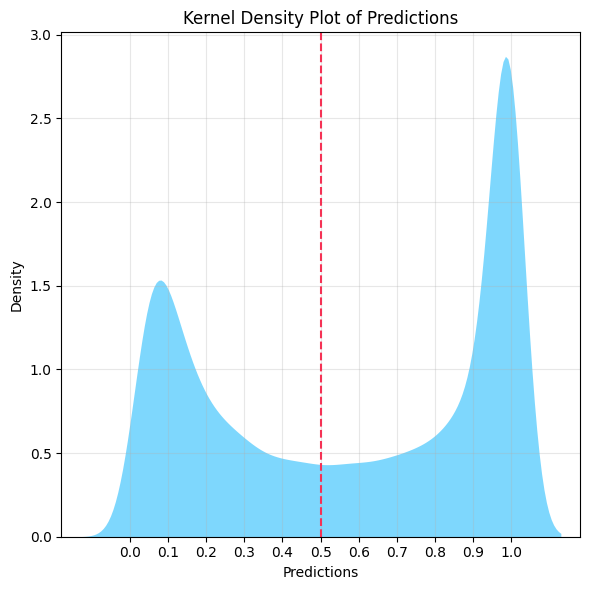

In [12]:
main(config)

### Export Results

In [44]:
from IPython.display import HTML, display

links = f"""
<div style='font-size: 15px; line-height: 2;'>
    <a href="{out_path.value}/prediction.csv" download>Prediction</a> |
    <a href="{out_path.value}/plot.png" download>Plot</a>
</div>
"""
display(HTML(links))
